<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Ejercicio 3
## Alumno: Jorge Heyul Chavez Arias 

## Custom embedddings con Gensim



### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto. Se utilizará canciones de bandas para generar los embeddings, es decir, que los vectores tendrán la forma en función de como esa banda haya utilizado las palabras en sus canciones.

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing
from gensim.models import Word2Vec

In [111]:
import urllib.request
import bs4 as bs
from io import StringIO
import re # Regular Expressions (regex)
import os
 

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [115]:
raw_html = urllib.request.urlopen('https://www.textos.info/varios/biblia/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text

article_text = article_text.lower()

In [116]:
print("Cantidad de caracteres en la nota:", len(article_text))

Cantidad de caracteres en la nota: 4493336


In [117]:
article_text[5:100]

'n el principio creó dios los cielos y la tierra. [2] la tierra era caos y confusión y oscuridad'

In [118]:
# substituir con regex con espacio vacío:
text = re.sub(r'\[[0-9]*\]', ' ', article_text) # substituir los números entre corchetes
# (notar que los corchetes son interpretados literalmente por los backlsash)
text = re.sub(r'\s+', ' ', text) # substituir más de un caracter de espacio, salto de línea o tabulación
 

In [120]:
text[0:100]

' en el principio creó dios los cielos y la tierra. la tierra era caos y confusión y oscuridad por en'

In [121]:
  
csvStringIO = StringIO(text)
  
df = pd.read_csv(csvStringIO,  header=None )
df = df.apply(lambda x: str(x))

df = df.T
#df =df.values.astype(str)
df=df.to_frame()
#df = pd.DataFrame(article_text)
df.head()


,0
0,0 en el principio creó dios los cielos y l...
1,0 y un viento de dios aleteaba por encima ...
2,0 y hubo luz. vio dios que la luz estaba b...
3,0 y apartó dios la luz de la oscuridad; y ...
4,0 y a la oscuridad la llamó noche. y atard...


In [122]:
type(df)

pandas.core.frame.DataFrame

In [125]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 64265


### 1 - Preprocesamiento

In [126]:
from keras.preprocessing.text import text_to_word_sequence

sentence_tokens = []
# Recorrer todas las filas y transformar las oraciones
# en una secuencia de palabras (esto podría realizarse con NLTK o spaCy también)
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

### 2 - Crear los vectores (word2vec)

In [128]:
from gensim.models.callbacks import CallbackAny2Vec
# Durante el entrenamiento gensim por defecto no informa el "loss" en cada época
# Sobracargamos el callback para poder tener esta información
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [140]:
# Crearmos el modelo generador de vectoeres
# En este caso utilizaremos la estructura modelo Skipgram
w2v_model = Word2Vec(min_count=10,    # frecuencia mínima de palabra para incluirla en el vocabulario
                     window=3,       # cant de palabras antes y desp de la predicha
                     size=500,       # dimensionalidad de los vectores 
                     negative=10,    # cantidad de negative samples... 0 es no se usa
                     workers=8,      # si tienen más cores pueden cambiar este valor
                     sg=1)           # modelo 0:CBOW  1:skipgram

In [141]:
# Buildear el vocabularui con los tokens
w2v_model.build_vocab(sentence_tokens)

In [142]:
# Cantidad de filas/docs encontradas en el corpus
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 64265


In [143]:
# Cantidad de words encontradas en el corpus
print("Cantidad de words distintas en el corpus:", len(w2v_model.wv.vocab))

Cantidad de words distintas en el corpus: 3404


### 3 - Entrenar el modelo generador

In [157]:
# Entrenamos el modelo generador de vectores
# Utilizamos nuestro callback
w2v_model.train(sentence_tokens,
                 total_examples=w2v_model.corpus_count,
                 epochs=100,
                 compute_loss = True,
                 callbacks=[callback()]
                 )

Loss after epoch 0: 260719.859375
Loss after epoch 1: 263846.953125
Loss after epoch 2: 263051.5
Loss after epoch 3: 260874.5
Loss after epoch 4: 259316.6875
Loss after epoch 5: 256825.5
Loss after epoch 6: 249130.25
Loss after epoch 7: 245964.5
Loss after epoch 8: 238195.5
Loss after epoch 9: 248823.25
Loss after epoch 10: 243721.0
Loss after epoch 11: 226356.25
Loss after epoch 12: 239667.25
Loss after epoch 13: 240646.25
Loss after epoch 14: 244041.25
Loss after epoch 15: 225990.5
Loss after epoch 16: 233038.5
Loss after epoch 17: 217193.5
Loss after epoch 18: 212368.5
Loss after epoch 19: 219811.5
Loss after epoch 20: 212564.5
Loss after epoch 21: 217924.5
Loss after epoch 22: 213431.5
Loss after epoch 23: 208317.0
Loss after epoch 24: 201304.0
Loss after epoch 25: 215079.0
Loss after epoch 26: 214009.5
Loss after epoch 27: 203991.0
Loss after epoch 28: 210788.0
Loss after epoch 29: 219937.5
Loss after epoch 30: 191064.5
Loss after epoch 31: 210351.5
Loss after epoch 32: 214185.0
L

(29234368, 74931000)

### 4 - Ensayar

In [185]:
# Palabras que MÁS se relacionan con...:

w2v_model.wv.most_similar(positive=["hambre"], topn=10)

[('peste', 0.3719528913497925),
 ('abismo', 0.2704380452632904),
 ('autoridad', 0.2576632499694824),
 ('espada', 0.257649302482605),
 ('granizo', 0.2494337260723114),
 ('tiende', 0.24872300028800964),
 ('abominación', 0.2473335713148117),
 ('diluvio', 0.24228237569332123),
 ('falsedad', 0.2402033656835556),
 ('nomb', 0.2400212585926056)]

In [186]:
w2v_model.wv.most_similar(negative=["hambre"], topn=10)

[('enseñas', 0.07400400936603546),
 ('apoyo', 0.06607940793037415),
 ('«el', 0.055948514491319656),
 ('vez', 0.039462536573410034),
 ('seguido', 0.037983812391757965),
 ('llamaba', 0.037586912512779236),
 ('oh', 0.03366624563932419),
 ('¿y', 0.033065155148506165),
 ('único', 0.0318826399743557),
 ('ropas', 0.03129200264811516)]

### 5 - Visualizar agrupación de vectores

In [135]:
from sklearn.decomposition import IncrementalPCA    
from sklearn.manifold import TSNE                   
import numpy as np                                  

def reduce_dimensions(model):
    num_dimensions = 2  

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

In [138]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

x_vals, y_vals, labels = reduce_dimensions(w2v_model)

MAX_WORDS=300
fig = px.scatter(x=x_vals[:MAX_WORDS], y=y_vals[:MAX_WORDS], text=labels[:MAX_WORDS])
fig.show()
#fig.show(renderer="colab") # esto para plotly en colab

d:\Users\heyul\anaconda3\envs\tensorf\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

d:\Users\heyul\anaconda3\envs\tensorf\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



### Conclusiones

- Se utilizó el corpus de la biblia alojada en : https://www.textos.info/varios/biblia/ebook 
- Se utilizó gensim para crear los vectores de embeddings 

A continuació se muestran los resultados:


- Palabra "odio", se aprecia que lo relaciona correctamente con "violento" y "homicida", y los siguientes poseen una similud coseno de 0.3 lo cual ya no es tan cercano. Y para los mas diferentes, los dos primeros no tienen mucha relacion "hubo" y "devolverá", sin embargo para los siguientes con 0.05 de similitud muy cercano a los anteriores si lo relaciona mejor: "bendito", "sagrado" y "oracion", lo cual se entiende que son palabras opuestas.

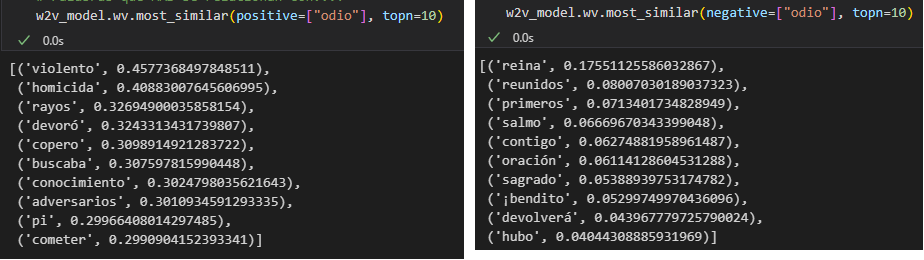


- El mismo procedimiento se realizó con la palabra "sacrificio" y lo relaciona bien, sin embargo, los negativos no. 

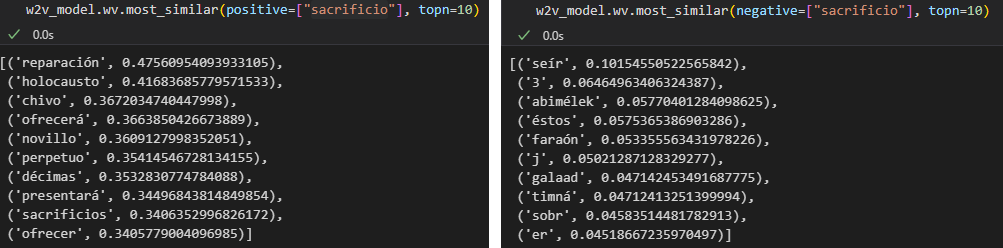

- La palabra "hambre" lo relaciona muy bien las positivas y negativas

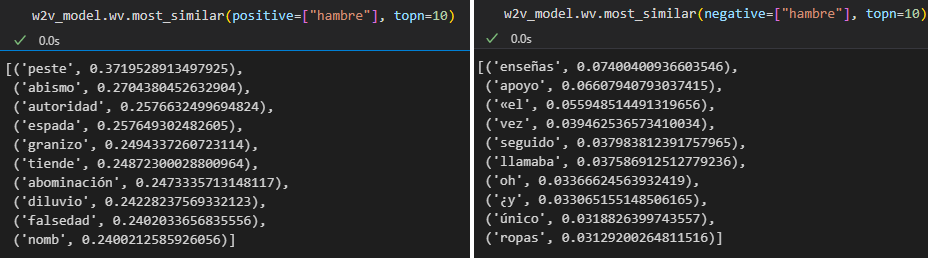

Se muestran algunas imagenes de los embedddings en 2D, y se puede ver su relación

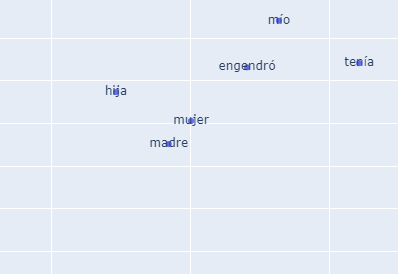
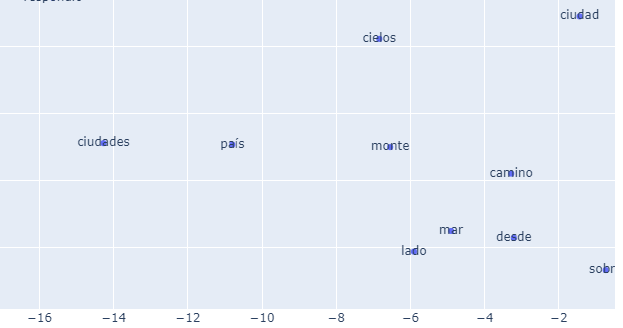